In [1]:
import os
import numpy as np
from tqdm.notebook import tqdm
import pickle

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical , plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add

In [3]:
BASE_DIR = r"C:\Users\Aditya\Documents\GenAI\ImageCaptioning\data"
WORKING_DIR = r"C:\Users\Aditya\Documents\GenAI\ImageCaptioning"

In [4]:
# Extracting image Features

# loading vgg16

model = VGG16()
model = Model(inputs=model.inputs , outputs = model.layers[-2].output)

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [5]:
# extract features from image

features = {}
directory = os.path.join(BASE_DIR, "Images")


In [ ]:

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path , target_size=(224,224))
    image = img_to_array(image)
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image , verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

In [ ]:
# save features

pickle.dump(features , open(os.path.join(WORKING_DIR , 'features_img.pkl') , 'wb'))

In [9]:
len(features)

8091

In [7]:
with open(os.path.join(WORKING_DIR , 'features_img.pkl') , 'rb') as f :
   features = pickle.load(f)

In [15]:
# load captions

with open(os.path.join(BASE_DIR , 'captions.txt') , 'r') as f :
    captions_doc = f.read()



In [16]:
# mapping img to caption

mapping = {}
for line in tqdm(captions_doc.split('\n')):
    # split by ','
    tokens = line.split(',')
    if len(line) < 2 :
        continue
    image_id , caption = tokens[0] , tokens[1]
    # rm extension - jpg
    image_id = image_id.split('.')[0]
    # caption list to string
    caption = "".join(caption)
    if image_id not in mapping :
        mapping[image_id] = []
    mapping[image_id].append(caption)


  0%|          | 0/40456 [00:00<?, ?it/s]

In [14]:
len(mapping)

8091

In [17]:
# preprocess txt data
#  
def clean(mapping):
    for key , captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            # to lower
            caption = caption.lower()
            # delete digits , sp chars
            caption = caption.replace('[^A-Za-z]','')
            # delete additional spaces
            caption = caption.replace('\s+' , ' ')
            # add start and end index
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption



<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Aditya\AppData\Local\Temp\ipykernel_14376\3187195918.py:12: SyntaxWarning: invalid escape sequence '\s'
  caption = caption.replace('\s+' , ' ')


In [18]:
# before preprocess

mapping["1007129816_e794419615"]

['A man in an orange hat starring at something .',
 'A man wears an orange hat and glasses .',
 'A man with gauges and glasses is wearing a Blitz hat .',
 'A man with glasses is wearing a beer can crocheted hat .',
 'The man with pierced ears is wearing glasses and an orange hat .']

In [19]:
clean(mapping)

In [20]:
mapping['1007129816_e794419615']

['startseq man in an orange hat starring at something endseq',
 'startseq man wears an orange hat and glasses endseq',
 'startseq man with gauges and glasses is wearing blitz hat endseq',
 'startseq man with glasses is wearing beer can crocheted hat endseq',
 'startseq the man with pierced ears is wearing glasses and an orange hat endseq']

In [21]:
all_captions = []
for key in mapping :
    for caption in mapping[key]:
        all_captions.append(caption)

In [22]:
len(all_captions)

40455

In [23]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [24]:
# tokenize the text

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [25]:
vocab_size

8313

In [26]:
# get max len of caption

max_length = max(len(caption.split()) for caption in all_captions)
max_length 

31

In [27]:
## Train Test Split

image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split :]

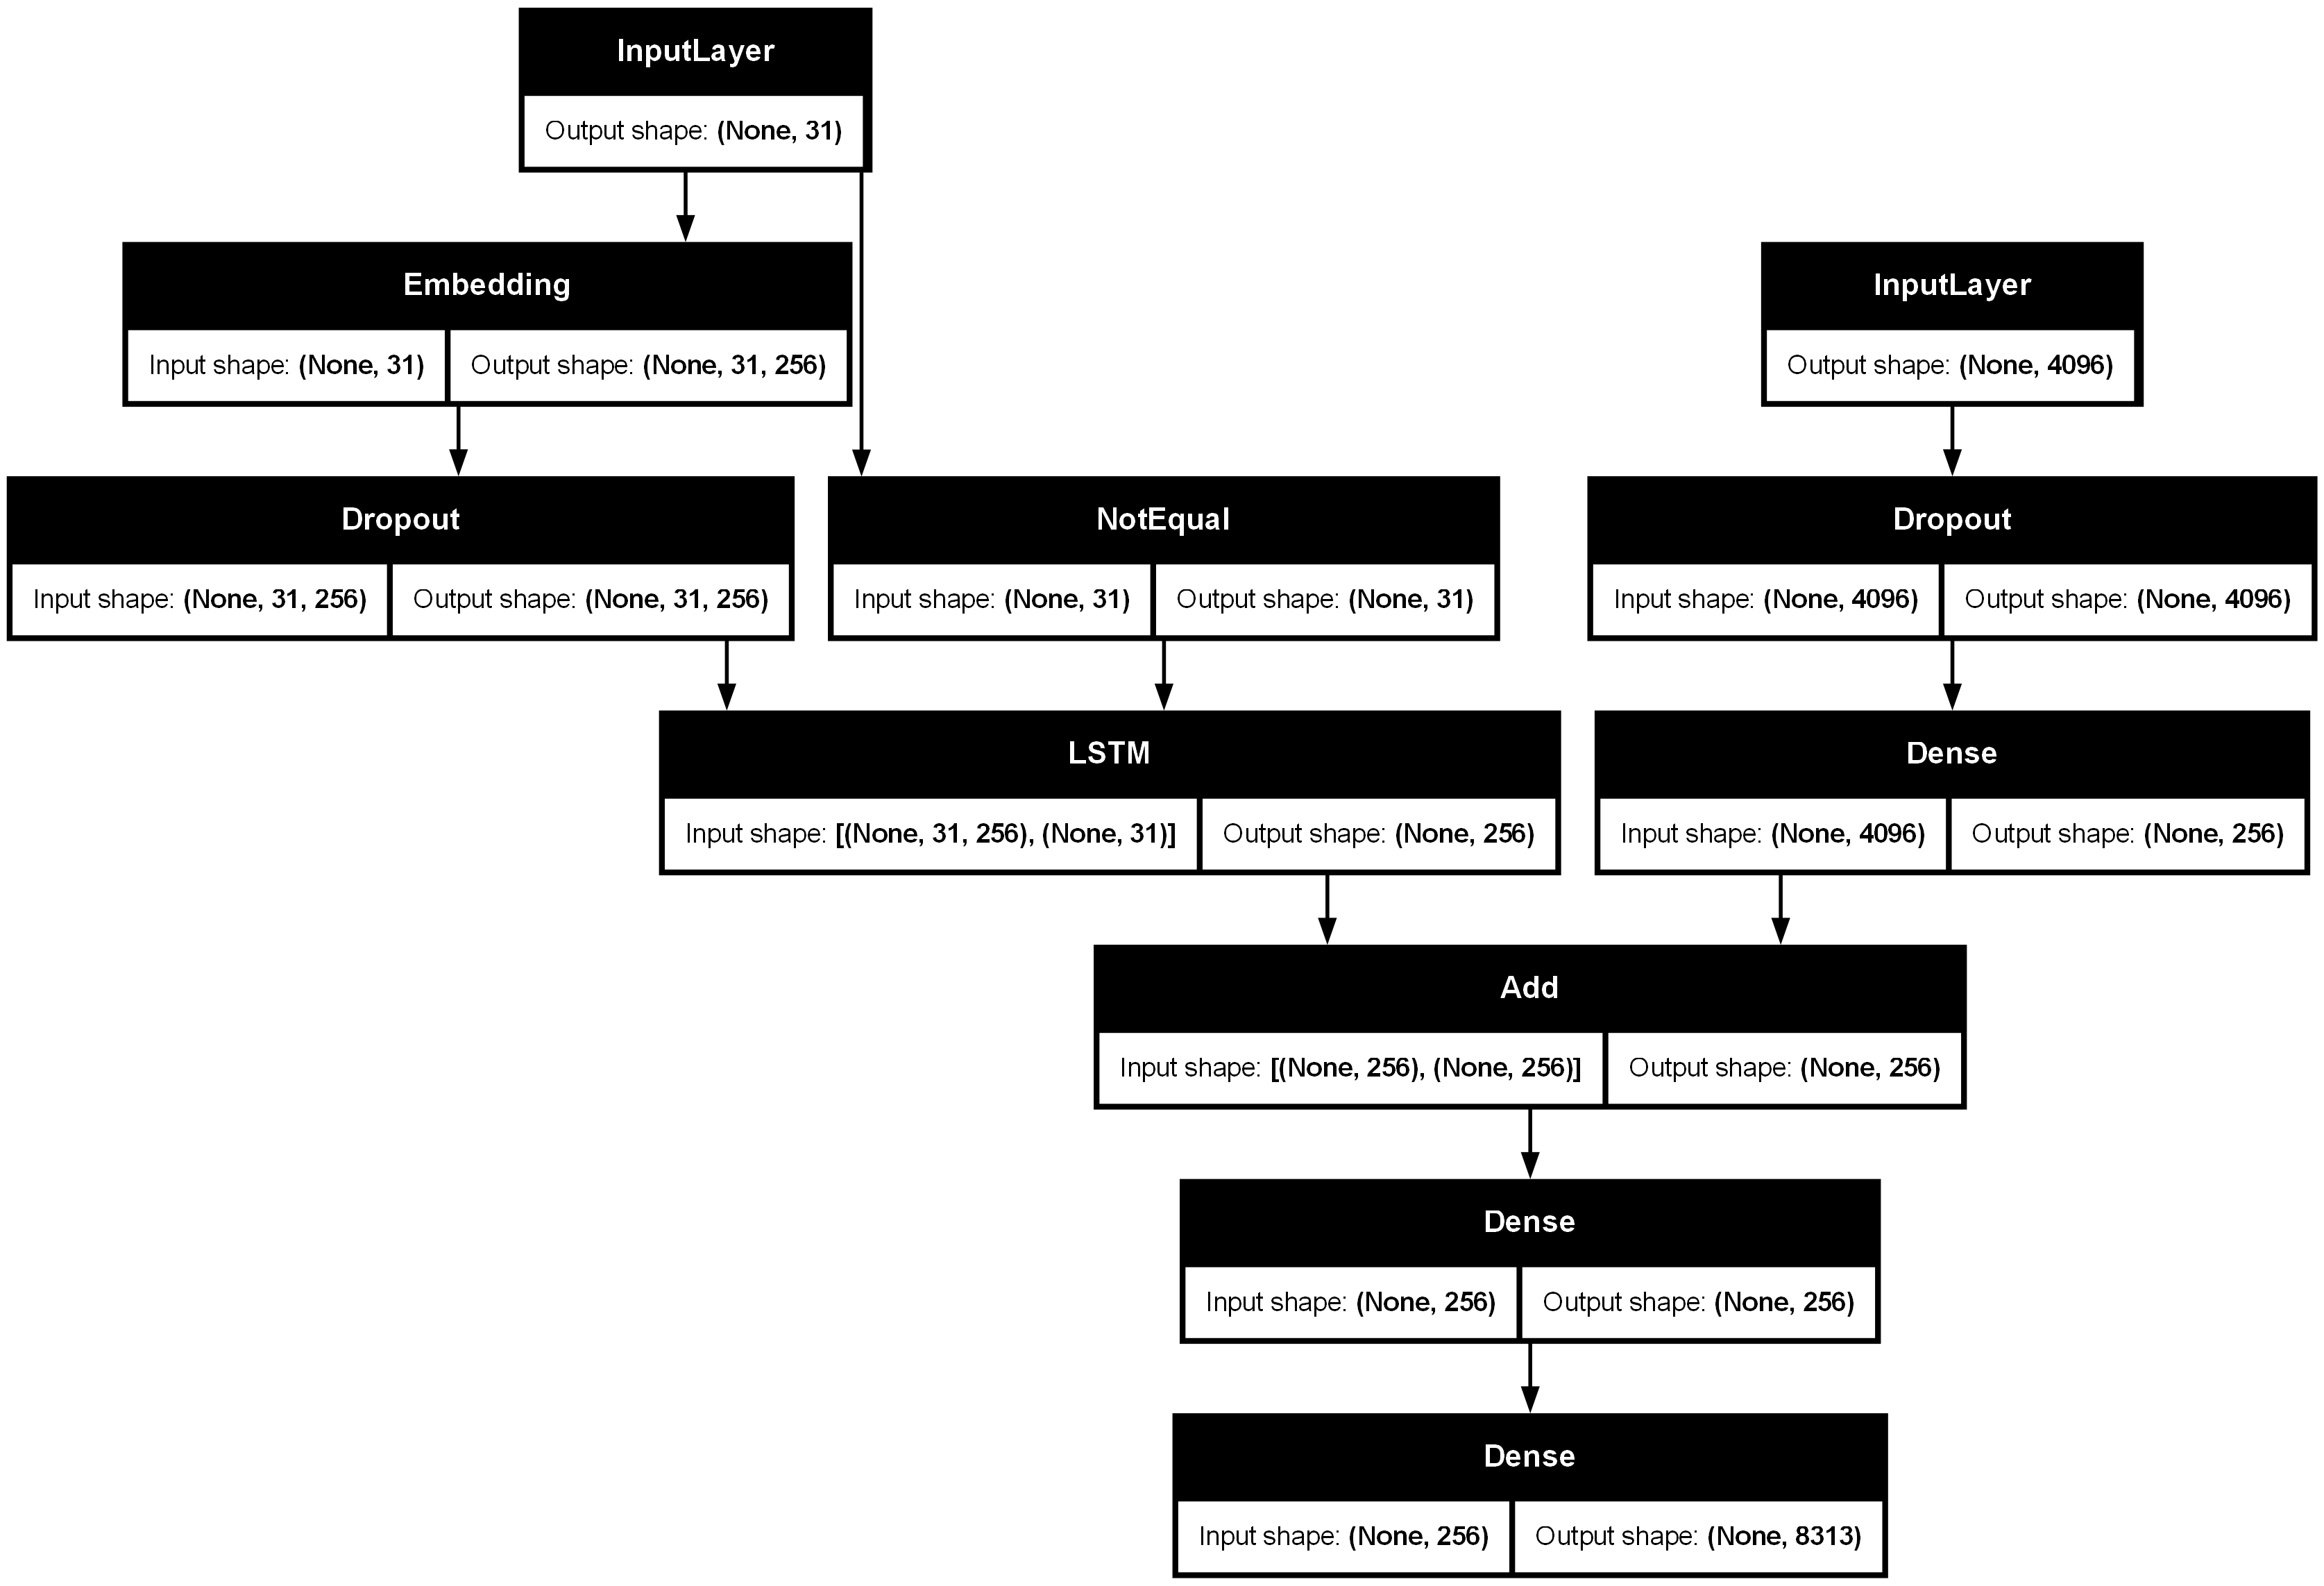

In [28]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [29]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 	num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
# train the model
epochs = 50
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [ ]:
model.save(WORKING_DIR + '/model_ep35.h5')

In [ ]:
def idx_to_word(integer , tokenizer):
    for word , index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [30]:
from nltk.translate.bleu_score import corpus_bleu


In [ ]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [ ]:
generate_caption("3162289423_4ca8915d0c.jpg")

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
import numpy as np

# Load the pre-trained VGG16 model
vgg16_model = VGG16(weights='imagenet')
vgg16_model = Model(inputs=vgg16_model.inputs, outputs=vgg16_model.layers[-2].output)  # Use the penultimate layer

def extract_features_vgg16(image_path):
    """
    Extract features from an image using the pre-trained VGG16 model.
    
    Args:
    - image_path: Path to the image file.

    Returns:
    - feature_vector: A NumPy array containing the extracted feature vector.
    """
    image = load_img(image_path, target_size=(224, 224))  # Resize to VGG16 input size
    image_array = img_to_array(image)  # Convert to NumPy array
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    image_array = preprocess_input(image_array)  # Preprocess for VGG16
    feature_vector = vgg16_model.predict(image_array, verbose=0)  # Extract features
    return feature_vector


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def generate_caption2(image_name):
    """
    Generate a caption for a given image.

    Args:
    - image_name: Name of the image file (e.g., "my_image.jpg").
    """
    # Load the image
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)

    # Handle feature extraction
    image_id = image_name.split('.')[0]
    if image_id in features:  # Image is part of the dataset
        feature_vector = features[image_id]
    else:  # Image is not part of the dataset, extract features dynamically
        print("Image not found in dataset, extracting features dynamically...")
        feature_vector = extract_features_vgg16(img_path)
    
    # Display the actual captions if available
    if image_id in mapping:
        print('---------------------Actual---------------------')
        captions = mapping[image_id]
        for caption in captions:
            print(caption)
    else:
        print("No actual captions available for this image.")

    # Predict the caption
    print('--------------------Predicted--------------------')
    y_pred = predict_caption(model, feature_vector, tokenizer, max_length)
    print(y_pred)

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()


In [ ]:
generate_caption2('pic1.jpg')

In [ ]:
generate_caption2('pic2.jpg')

In [ ]:
generate_caption2('pic3.jpg')